# Exercise 1
(a) Consider the nonlinear equation:

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

Using:
- Central differences for the second order spatial derivative
- Upwind difference for the first order spatial derivative
- Implicit Euler for time

$$
F_i(\mathbf{U}) = \frac{U^k_i - U^{k-1}_i}{\Delta t} + U^k_i\left(\frac{U^k_i - U^k_{i-1}}{h}\right) - \nu\left(\frac{U^k_{i+1} - 2U^k_i + U^k_{i-1}}{h^2}\right)
$$


In [1]:
import numpy as np

def fun_burgers(uk, ukp, dt, h, nu,ua,ub):

  # Nonlinear residual function
  # Input: uk    -  vector U^k (dimension m x 1)
  #        ukp -  previous solution (dimension m x 1)
  #        dt   - time-step
  #        h    - spatial grid size
  #        nu    - kinematic viscosity
  #        ua    - left boundary value
  #        ub    - right boundary value
  # Output: f   - nonlinear functions evaluated at u

  m = ukp.size
  f = np.zeros( (m-2, 1) )
  #ua = ukp[0]
  #ub = ukp[-1]

  # Difference equation at the left boundary
  f[0] = ( uk[0] - ukp[1] ) / dt + uk[0] * ( uk[0] - ua ) / h - nu * ( uk[1] - 2*uk[0] + ua ) / h**2 

  # Difference equations at each internal node
  for i in range(1,m-3):
    f[i] = ( uk[i] - ukp[i+1] ) / dt + uk[i] * ( uk[i] - uk[i-1] ) / h - nu * ( uk[i+1] - 2*uk[i] + uk[i-1] ) / h**2 

  # Difference equation at the right boundary
  f[m-3] = ( uk[m-3] - ukp[m-2] ) / dt + uk[m-3] * ( uk[m-3] - uk[m-4] ) / h - nu * ( ub - 2*uk[m-3] + uk[m-4] ) / h**2 

  return f


(b) We can derive analytical formulas for the non zero elements of the Jacobian:

$$
\frac{\partial F_i}{\partial U_{i-1}} = -\frac{1}{h}\left(U_i -\frac{\nu}{h}\right)
$$

$$
\frac{\partial F_i}{\partial U_{i}} = \frac{1}{\Delta t} +  \left(\frac{2U_i - U_{i-1}}{h}\right) + \frac{2\nu U_i}{h^2}
$$

$$
\frac{\partial F_i}{\partial U_{i+1}} = \frac{-\nu}{h^2}
$$

(c) Jacobian solver.

In [2]:
import numpy as np
import copy
def fdJacobian(x,n,fnon,F0,*fnonargs):
  J = np.zeros((n,n), dtype=np.float64)
  h = 10e-8

  for k in range(0,n):
    xb = copy.copy(x)
    xb[k] = xb[k] + h

    F = eval(fnon)(xb,*fnonargs)

    for i in range(0,n):
        J[i,k] = (F[i] - F0[i]) / h

  return J

Time stepping loop implementing the burgers equation.

In [3]:
import matplotlib.pyplot as plt
def burgersModel(function, dtIn, Tend, hIn , nu, ua, ub):

  # Implicit Euler in time, finite difference in space
  # numerical model for the Fisher Equation
  #  function sols = fisherModel( dtIn, nTimeSteps, mIn )
  # Input:  dtIn       - time step size
  #         nTimeSteps - number of time steps
  #         mIn        - grid dimension
  # Output: sols       - array of solution vectors u^k

  dt = dtIn   # time step size
  h = hIn # grid size
  m = int(1+ 1/h)     # dimension of spatial mesh for [X1,X2]
  n = m-2     # number of nonlinear equations (excluding boundary condition)
  nTimeSteps = int(Tend/dtIn)
  # Initial and boundary conditions
  uOld = initialData( h )
  u0 = np.zeros( (n,1) )
  
  # Create an array for the solutions in time
  sols = np.array(uOld)
  Its = 0

  # Time stepping loop
  for k in range( 0, nTimeSteps ):
    print('Time step: {0:1.0f}'.format(k))

    # Use previous time step as the Newton initial guess
    u0 = uOld[1:n+1]

    # Call the Newton solver
    u, It = myNewtonSys(function, "fdJacobian", u0, 1e-6, 10, uOld, dt, h, nu, ua, ub)

    # Update the previous time step
    uOld[1:n+1] = u[0:n]

    # Store the solution vector
    sols = np.hstack((sols,uOld))
    #Track total iterations
    Its += It

  print(f'Total Newton Iterations = {Its}')
  return sols

Create a function to solve systems using the newton method.

In [4]:
import numpy as np
from numpy.linalg import norm

def myNewtonSys(fnon, jac, x0, tol, maxk, *fnonargs):
    # fnon     - name of the nonlinear function f(x)
    # jac      - name of the Jacobian function J(x)
    # x0       - initial guess for the solution x0
    # tol      - stopping tolerance for Newton's iteration
    # maxk     - maximum number of Newton iterations before stopping
    # fnonargs - optional arguments that will be passed to the nonlinear function (useful for additional function parameters)

    k = 0
    x = x0

    F = eval(fnon)(x,*fnonargs)
    n = F.size

    print(' k    f(xk)')

    # Main Newton loop
    while (norm(F,2) > tol and k <= maxk):
        # Evaluate Jacobian matrix
        J = eval(jac)(x,n,fnon,F,*fnonargs)

        # Take Newton step by solving the tangent problem
        delta = np.linalg.solve(J,-F)
        x = x + delta

        F = eval(fnon)(x,*fnonargs)

        print('{0:2.0f}  {1:2.2e}'.format(k, norm(F,2)))
        k += 1

    if (k >= maxk):
        print('Not converged')
    else:
        return x, k

Define the initial data

Text(0, 0.5, 'Solution u')

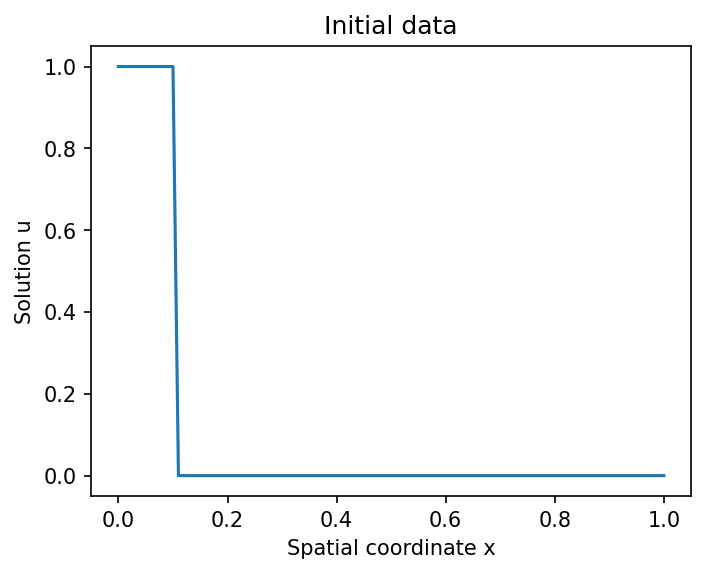

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def initialData( h ):

  # Initial solution profile
  # Input: grid size m
  # Output: initial condition u

  # spatial domain endpoints
  xL = 0
  xR = 1

  m = int(1 + (xR - xL) / h)                      # mesh size
  x = np.linspace(xL, xR, m).reshape((m, 1)) # grid points

  v = 1-np.heaviside(x-0.1,0)

  # Boundary conditions
  uL = v[0]
  uR = v[m-1]

  return v

v = initialData(0.01)
x = np.linspace(0,1,int(1+ 1/0.01)).reshape((int(1+ 1/0.01),1))
fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0,0,1,1])
ax.plot(x,v)

ax.set_title('Initial data')
ax.set_xlabel('Spatial coordinate x')
ax.set_ylabel('Solution u')


Solve the system.

In [6]:
hIn = 0.01
Tend = 1
dt = 0.01
nu = 0.01
sols = burgersModel( "fun_burgers", dt, Tend, hIn , nu, 1, 0)


Time step: 0
 k    f(xk)
 0  3.64e+01


/tmp/ipykernel_12031/989455296.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J[i,k] = (F[i] - F0[i]) / h


 1  1.57e+00
 2  2.77e-03
 3  9.93e-09
Time step: 1
 k    f(xk)
 0  3.32e+00
 1  1.25e-02
 2  1.43e-07
Time step: 2
 k    f(xk)
 0  8.31e-01
 1  7.34e-04
 2  5.07e-10
Time step: 3
 k    f(xk)
 0  4.26e-01
 1  1.58e-04
 2  2.77e-11
Time step: 4
 k    f(xk)
 0  2.88e-01
 1  6.97e-05
 2  5.86e-12
Time step: 5
 k    f(xk)
 0  2.20e-01
 1  3.87e-05
 2  2.74e-12
Time step: 6
 k    f(xk)
 0  1.81e-01
 1  2.52e-05
 2  1.59e-12
Time step: 7
 k    f(xk)
 0  1.55e-01
 1  1.80e-05
 2  1.08e-12
Time step: 8
 k    f(xk)
 0  1.37e-01
 1  1.38e-05
 2  8.01e-13
Time step: 9
 k    f(xk)
 0  1.24e-01
 1  1.10e-05
 2  6.42e-13
Time step: 10
 k    f(xk)
 0  1.13e-01
 1  9.12e-06
 2  5.19e-13
Time step: 11
 k    f(xk)
 0  1.05e-01
 1  7.76e-06
 2  4.47e-13
Time step: 12
 k    f(xk)
 0  9.91e-02
 1  6.76e-06
 2  3.91e-13
Time step: 13
 k    f(xk)
 0  9.38e-02
 1  5.98e-06
 2  3.47e-13
Time step: 14
 k    f(xk)
 0  8.93e-02
 1  5.38e-06
 2  3.11e-13
Time step: 15
 k    f(xk)
 0  8.56e-02
 1  4.89e-06
 2  2.82

Text(0, 0.5, 'u(x,t)')

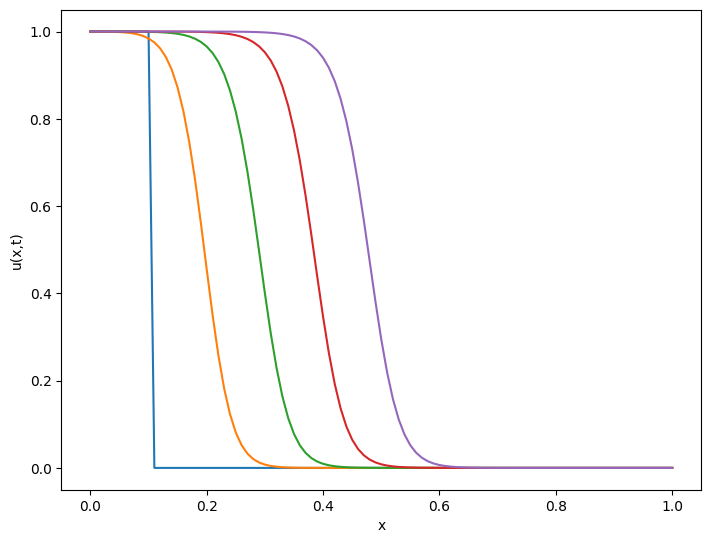

In [7]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)

fig=plt.figure()
ax=fig.add_axes([0.0,0.0,1.0,1.0])
for t in range(0, int(tPts/20)):
  ax.plot(x,sols[:,t*20])
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')

Text(0.5, 1.0, 'Solution to Burgers equation for $\\nu = 0.01$')

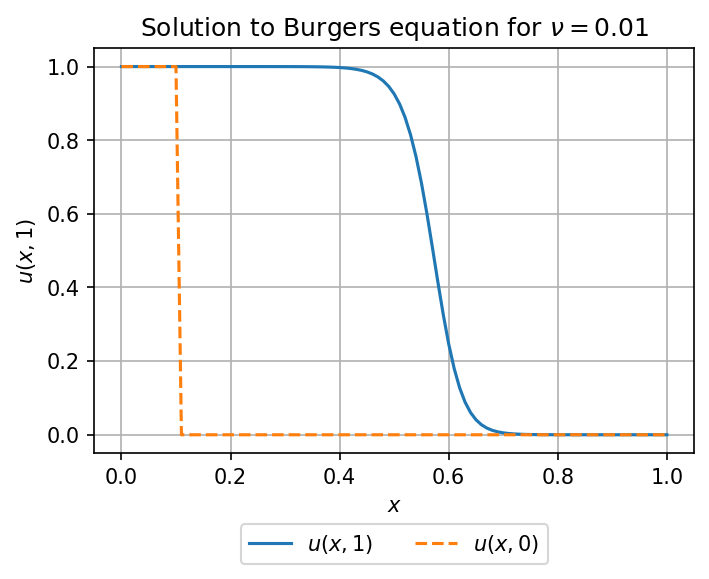

In [8]:
from matplotlib import pyplot as plt
import numpy as np
v = initialData(0.01)

fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0.0,0.0,1.0,1.0])
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)
ax.plot(x,sols[:,tPts], label="$u(x,1)$")
ax.plot(x,v,'--', label="$u(x,0)$")


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, ncol=2)
ax.grid(True)
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,1)$')
ax.set_title('Solution to Burgers equation for $\\nu = 0.01$')

(d) By tracking position of the midpoint of the wavefront over each time step, the approximate wavefront velocity can be calculated:

$$
v^k = \frac{x^T_{mid} - x^{0}_{mid} }{T},
$$

where,

$$
u(x_{mid}) = 0.5
$$


We have the sols for each time step and an x axis. We need to find the closes value to 0.5 for each time step and relate that to the x of the same index in the array.

In [9]:
umid = 0.5
#Values of u at all timesteps at the end of the domain
xindex = np.copy(sols[:,-1]) - umid
xmax = x[np.argmin(abs(xindex))]
velocity = xmax - 0.1
print(f'Location of xmid u(xmid,T) = 0.5 is {xmax:.2f}')
print(f'Wavefront speed is {velocity:.2f}')

Location of xmid u(xmid,T) = 0.5 is 0.57
Wavefront speed is 0.47


(e) The discretisation of Burgers' equation can be modified: 


$$
F_i(\mathbf{U}) = \frac{U^k_i - U^{k-1}_i}{\Delta t} + U^k_i\left(\frac{U^k_i - U^k_{i-1}}{h}\right) - \nu\left(\frac{U^k_{i+1} - 2U^k_i + U^k_{i-1}}{h^2}\right),
$$

to use upwind differences for the convection term:
$$
F_i(\mathbf{U}) = \frac{U^k_i - U^{k-1}_i}{\Delta t} + U^k_i\left(\frac{U^k_{i+1} - U^k_{i}}{h}\right) - \nu\left(\frac{U^k_{i+1} - 2U^k_i + U^k_{i-1}}{h^2}\right),
$$


In [13]:
import numpy as np

def fun_burgers_upwind(uk, ukp, dt, h, nu, ua, ub):

  # Nonlinear residual function
  # Input: uk    -  vector U^k (dimension m x 1)
  #        ukp -  previous solution (dimension m x 1)
  #        dt   - time-step
  #        h    - spatial grid size
  #        nu    - kinematic viscosity
  #        ua    - left boundary value
  #        ub    - right boundary value
  # Output: f   - nonlinear functions evaluated at u

  m = ukp.size
  f = np.zeros( (m-2, 1) )
  #ua = ukp[0]
  #ub = ukp[m-1]

  # Difference equation at the left boundary
  f[0] = ( uk[0] - ukp[1] ) / dt + uk[0] * ( uk[1] - uk[0] ) / h - nu * ( uk[1] - 2*uk[0] + ua ) / h**2 

  # Difference equations at each internal node
  for i in range(1,m-3):
    f[i] = ( uk[i] - ukp[i+1] ) / dt + uk[i] * ( uk[i+1] - uk[i] ) / h - nu * ( uk[i+1] - 2*uk[i] + uk[i-1] ) / h**2 

  # Difference equation at the right boundary
  f[m-3] = ( uk[m-3] - ukp[m-2] ) / dt + uk[m-3] * ( ub - uk[m-3] ) / h - nu * ( ub - 2*uk[m-3] + uk[m-4] ) / h**2 

  return f

In [14]:
hIn = 0.01
Tend = 1
dt = 0.01
nu = 0.01
solsupwind = burgersModel( "fun_burgers_upwind", dt, Tend, hIn , nu, 1, 0)

Time step: 0
 k    f(xk)
 0  9.11e+00


/tmp/ipykernel_12031/989455296.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J[i,k] = (F[i] - F0[i]) / h


 1  9.50e-02
 2  8.69e-06
 3  5.70e-13
Time step: 1
 k    f(xk)
 0  1.86e+00
 1  4.82e-03
 2  2.20e-08
Time step: 2
 k    f(xk)
 0  1.03e+00
 1  1.11e-03
 2  1.13e-09
Time step: 3
 k    f(xk)
 0  7.96e-01
 1  7.29e-04
 2  6.06e-10
Time step: 4
 k    f(xk)
 0  6.22e-01
 1  4.87e-04
 2  3.72e-10
Time step: 5
 k    f(xk)
 0  5.24e-01
 1  3.44e-04
 2  1.09e-10
Time step: 6
 k    f(xk)
 0  4.59e-01
 1  2.65e-04
 2  9.56e-11
Time step: 7
 k    f(xk)
 0  4.13e-01
 1  2.08e-04
 2  4.81e-11
Time step: 8
 k    f(xk)
 0  3.79e-01
 1  1.77e-04
 2  3.44e-11
Time step: 9
 k    f(xk)
 0  3.53e-01
 1  1.47e-04
 2  2.82e-11
Time step: 10
 k    f(xk)
 0  3.33e-01
 1  1.33e-04
 2  1.47e-11
Time step: 11
 k    f(xk)
 0  3.16e-01
 1  1.16e-04
 2  1.88e-11
Time step: 12
 k    f(xk)
 0  3.03e-01
 1  1.08e-04
 2  7.44e-12
Time step: 13
 k    f(xk)
 0  2.91e-01
 1  9.71e-05
 2  1.34e-11
Time step: 14
 k    f(xk)
 0  2.82e-01
 1  9.20e-05
 2  5.49e-12
Time step: 15
 k    f(xk)
 0  2.74e-01
 1  8.50e-05
 2  9.63

Text(0, 0.5, 'u(x,t)')

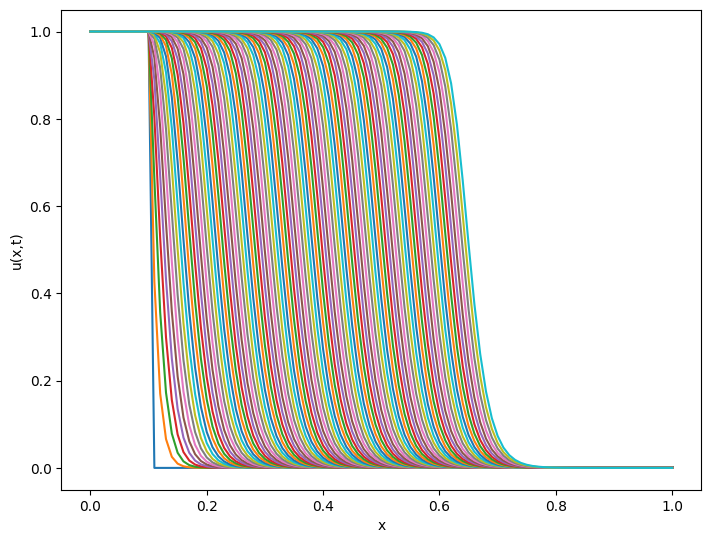

In [15]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)

fig=plt.figure()
ax=fig.add_axes([0.0,0.0,1.0,1.0])
for t in range(0, tPts):
  ax.plot(x,solsupwind[:,t])
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')

Text(0.5, 1.0, 'Solution to Burgers equation for $\\nu = 0.01$')

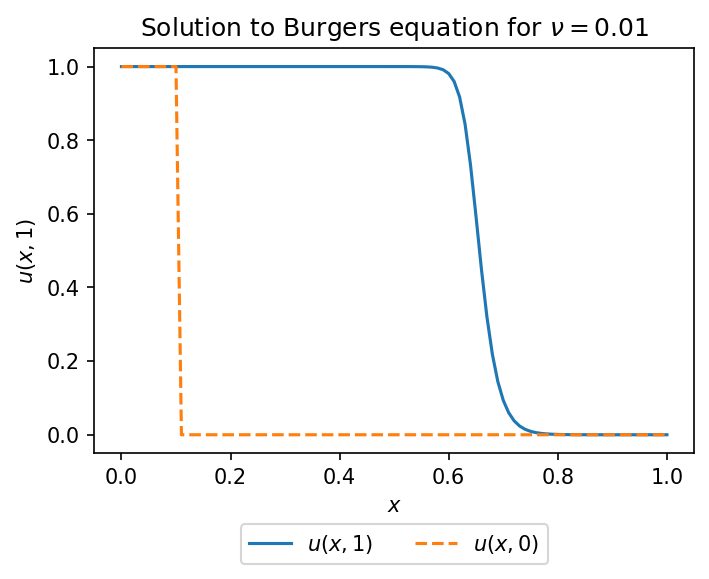

In [16]:
from matplotlib import pyplot as plt
import numpy as np
v = initialData(0.01)

fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0.0,0.0,1.0,1.0])
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)
ax.plot(x,solsupwind[:,tPts], label="$u(x,1)$")
ax.plot(x,v,'--', label="$u(x,0)$")


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, ncol=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,1)$')
ax.set_title('Solution to Burgers equation for $\\nu = 0.01$')

In [17]:
from matplotlib import rc
rc('animation', html='jshtml')
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

fig = plt.figure(figsize=(8,6))
ax = plt.axes( )
plt.close()

def frame(w):
    ax.clear()
    global x,y,z
    x=np.linspace(0, 1, mPts)
    ax.set_xlabel('x')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylabel('u(x,t)')
    ax.set_ylim(0.0, 1.0)
    plot = ax.plot(x, solsupwind[:,w])

In [ ]:
anim2 = animation.FuncAnimation(fig, frame, frames=tPts, blit=False, repeat=True)

In [ ]:
anim2

In [18]:
umid = 0.5
xmid_index = np.zeros(len(solsupwind[0,:]), int)
vmid = np.zeros(len(xmid_index) -1, float)
for k in range(0,len(solsupwind[0,:])):
    solmid = abs(np.array(solsupwind[:,k]) - umid)
    xmid_index[k] = np.argmin(solmid)
    if k > 0:
        vmid[k-1] = (x[xmid_index[k]] - x[xmid_index[k-1]]) / dt



ValueError: x and y must have same first dimension, but have shapes (100,) and (99,)

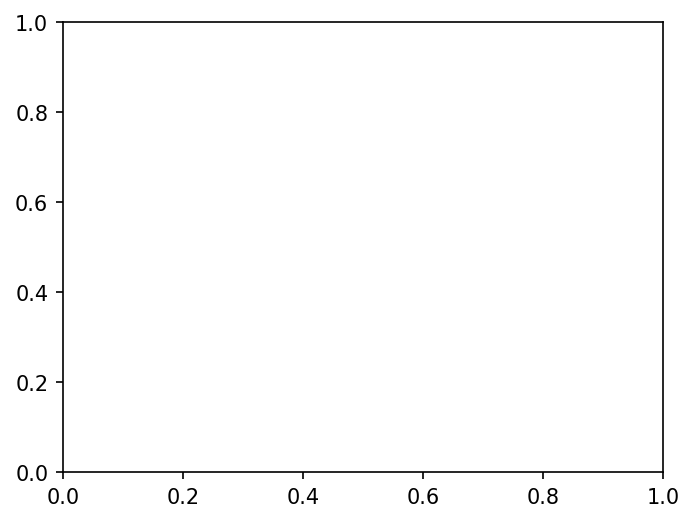

In [20]:
from matplotlib import pyplot as plt
import numpy as np

trange2 = np.linspace(0,1,101)

fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0.0,0.0,1.0,1.0])

ax.plot(trange2[1:],vmid[1:])
ax.plot(trange2,x[xmid_index])
ax.set_xlabel('$t$')
ax.set_ylabel('$v$')
ax.set_title('Approximate wavefront speed for the solution to Burgers\' equation with $\\nu = 0.01$')

Find the time when u(1,1) = 0.5

solsupwind[i,j]

i = t
j = x

In [21]:
#Velocity is:

#vel = 1/Ttravel
#Ttravel is the time at which u(1,Ttravel) = 0.5

#Extract x=1 for all time steps
#TODO: Issue with the initial condition and also even valued time steps

umid = 0.5
#Values of u at all timesteps at the end of the domain
tindex = np.copy(solsupwind[50,:]) - umid
tmin = np.argmin(abs(tindex))
velocity = x[50] / tmin
print(f'Time at which u(1,T) = 0.5 is {tmin}')
print(f'Wavefront speed is {velocity}')



Time at which u(1,T) = 0.5 is 71
Wavefront speed is 0.007042253521126761


The viscosity can be varied in both solvers:

In [23]:
hIn = 0.01
Tend = 1
dt = 0.01
nu = 0.001
solsupwind = burgersModel( "fun_burgers_upwind", dt, Tend, hIn , nu, 1, 0)

Time step: 0
 k    f(xk)
 0  8.00e+08


/tmp/ipykernel_12031/989455296.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J[i,k] = (F[i] - F0[i]) / h


 1  2.00e+08
 2  5.00e+07
 3  1.25e+07
 4  3.13e+06
 5  7.81e+05
 6  1.95e+05
 7  4.88e+04
 8  1.22e+04
 9  6.34e+03
10  1.58e+03
Not converged


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
hIn = 0.01
Tend = 1
dt = 0.01
nu = 0.001
solsupwind = burgersModel( "fun_burgers", dt, Tend, hIn , nu)

Time step: 0
 k    f(xk)
 0  2.72e+01


/tmp/ipykernel_28233/989455296.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J[i,k] = (F[i] - F0[i]) / h


 1  4.84e+00
 2  3.69e-01
 3  2.97e-03
 4  2.00e-07
Time step: 1
 k    f(xk)
 0  1.12e+01
 1  6.82e-01
 2  3.58e-03
 3  9.20e-08
Time step: 2
 k    f(xk)
 0  4.88e+00
 1  8.72e-02
 2  3.51e-05
 3  7.07e-12
Time step: 3
 k    f(xk)
 0  1.97e+00
 1  1.24e-02
 2  4.64e-07
Time step: 4
 k    f(xk)
 0  2.06e+00
 1  1.67e-02
 2  1.11e-06
 3  9.97e-14
Time step: 5
 k    f(xk)
 0  1.62e+00
 1  8.49e-03
 2  2.83e-07
Time step: 6
 k    f(xk)
 0  1.33e+00
 1  6.42e-03
 2  2.13e-07
Time step: 7
 k    f(xk)
 0  1.49e+00
 1  7.53e-03
 2  2.04e-07
Time step: 8
 k    f(xk)
 0  1.13e+00
 1  4.52e-03
 2  6.63e-08
Time step: 9
 k    f(xk)
 0  1.28e+00
 1  6.24e-03
 2  1.80e-07
Time step: 10
 k    f(xk)
 0  1.22e+00
 1  4.45e-03
 2  8.25e-08
Time step: 11
 k    f(xk)
 0  1.04e+00
 1  4.11e-03
 2  1.01e-07
Time step: 12
 k    f(xk)
 0  1.25e+00
 1  5.43e-03
 2  1.05e-07
Time step: 13
 k    f(xk)
 0  1.04e+00
 1  3.54e-03
 2  4.00e-08
Time step: 14
 k    f(xk)
 0  1.10e+00
 1  4.74e-03
 2  1.30e-07
Time ste

Text(0, 0.5, 'u(x,t)')

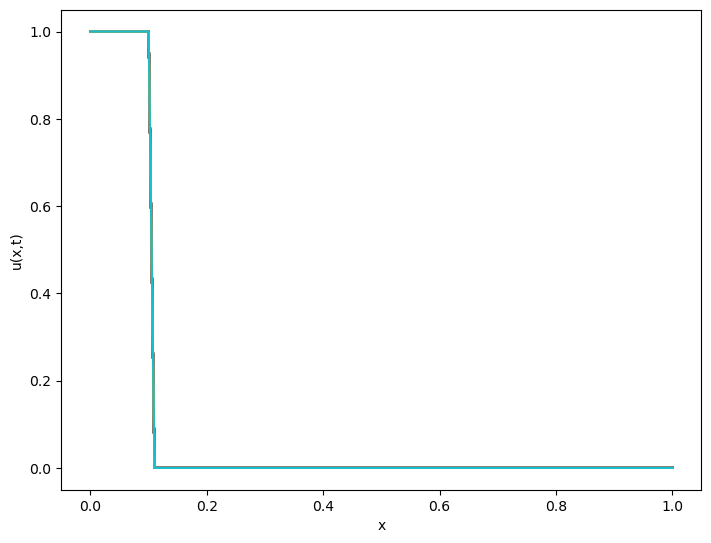

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)

fig=plt.figure()
ax=fig.add_axes([0.0,0.0,1.0,1.0])
for t in range(0, tPts):
  ax.plot(x,solsupwind[:,t])
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')

In [ ]:
#Velocity is:

#vel = 1/Ttravel
#Ttravel is the time at which u(1,Ttravel) = 0.5

#Extract x=1 for all time steps
#TODO: Issue with the initial condition and also even valued time steps

umid = 0.5
#Values of u at all timesteps at the end of the domain
tindex = np.copy(solsupwind[50,:]) - umid
tmin = np.argmin(abs(tindex))
velocity = x[50] / tmin
print(f'Time at which u(1,T) = 0.5 is {tmin}')
print(f'Wavefront speed is {velocity}')



Time at which u(1,T) = 0.5 is 100
Wavefront speed is 0.005


In [ ]:
hIn = 0.01
Tend = 1
dt = 0.01
nu = 0.0
solsupwind2 = burgersModel( "fun_burgers", dt, Tend, hIn , nu)

Time step: 0
 k    f(xk)
Time step: 1
 k    f(xk)
Time step: 2
 k    f(xk)
Time step: 3
 k    f(xk)
Time step: 4
 k    f(xk)
Time step: 5
 k    f(xk)
Time step: 6
 k    f(xk)
Time step: 7
 k    f(xk)
Time step: 8
 k    f(xk)
Time step: 9
 k    f(xk)
Time step: 10
 k    f(xk)
Time step: 11
 k    f(xk)
Time step: 12
 k    f(xk)
Time step: 13
 k    f(xk)
Time step: 14
 k    f(xk)
Time step: 15
 k    f(xk)
Time step: 16
 k    f(xk)
Time step: 17
 k    f(xk)
Time step: 18
 k    f(xk)
Time step: 19
 k    f(xk)
Time step: 20
 k    f(xk)
Time step: 21
 k    f(xk)
Time step: 22
 k    f(xk)
Time step: 23
 k    f(xk)
Time step: 24
 k    f(xk)
Time step: 25
 k    f(xk)
Time step: 26
 k    f(xk)
Time step: 27
 k    f(xk)
Time step: 28
 k    f(xk)
Time step: 29
 k    f(xk)
Time step: 30
 k    f(xk)
Time step: 31
 k    f(xk)
Time step: 32
 k    f(xk)
Time step: 33
 k    f(xk)
Time step: 34
 k    f(xk)
Time step: 35
 k    f(xk)
Time step: 36
 k    f(xk)
Time step: 37
 k    f(xk)
Time step: 38
 k    f(

Text(0, 0.5, 'u(x,t)')

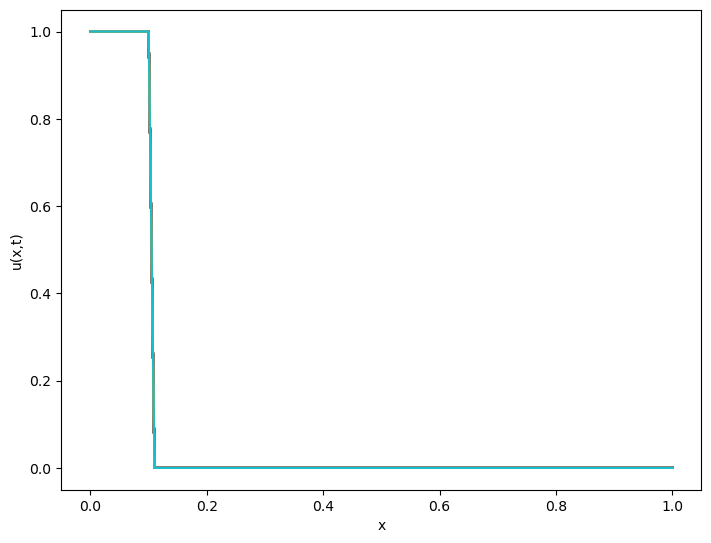

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)

fig=plt.figure()
ax=fig.add_axes([0.0,0.0,1.0,1.0])
for t in range(0, tPts):
  ax.plot(x,solsupwind2[:,t])
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')